<a href="https://colab.research.google.com/github/abysssdweller/QML/blob/main/PHM/vqc_rul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
!pip install pennylane
import pandas as pd
import numpy as np
import tensorflow as tf
import pennylane as qml
from pennylane import qnn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


# Merging Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get install -y unrar
import os

rar_folder = "/content/drive/MyDrive/IMS_Data"
extract_to = "/content/IMS"

os.makedirs(extract_to, exist_ok=True)

for rar_file in ["1st_test.rar", "2nd_test.rar", "3rd_test.rar"]:
    rar_path = os.path.join(rar_folder, rar_file)
    !unrar x -o+ "{rar_path}" "{extract_to}"

Streaming output truncated to the last 5000 lines.
Extracting  /content/IMS/4th_test/txt/2004.03.13.14.12.46                 17%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.14.22.46                 17%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.14.32.46                 17%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.14.42.46                 17%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.14.52.46                 17%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.15.02.46                 18%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.15.12.46                 18%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.15.22.46                 18%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.15.32.46                 18%  OK 
Extracting  /content/IMS/4th_test/txt/2004.03.13.15.42.46                 18%  OK 
Extracting  /content/IMS/4th_

In [ ]:
from pathlib import Path

BASE_IMS_DIR = Path("/content/IMS")
dataset_path_1st = BASE_IMS_DIR / "1st_test"
dataset_path_2nd = BASE_IMS_DIR / "2nd_test"
dataset_path_3rd = BASE_IMS_DIR / "3rd_test"

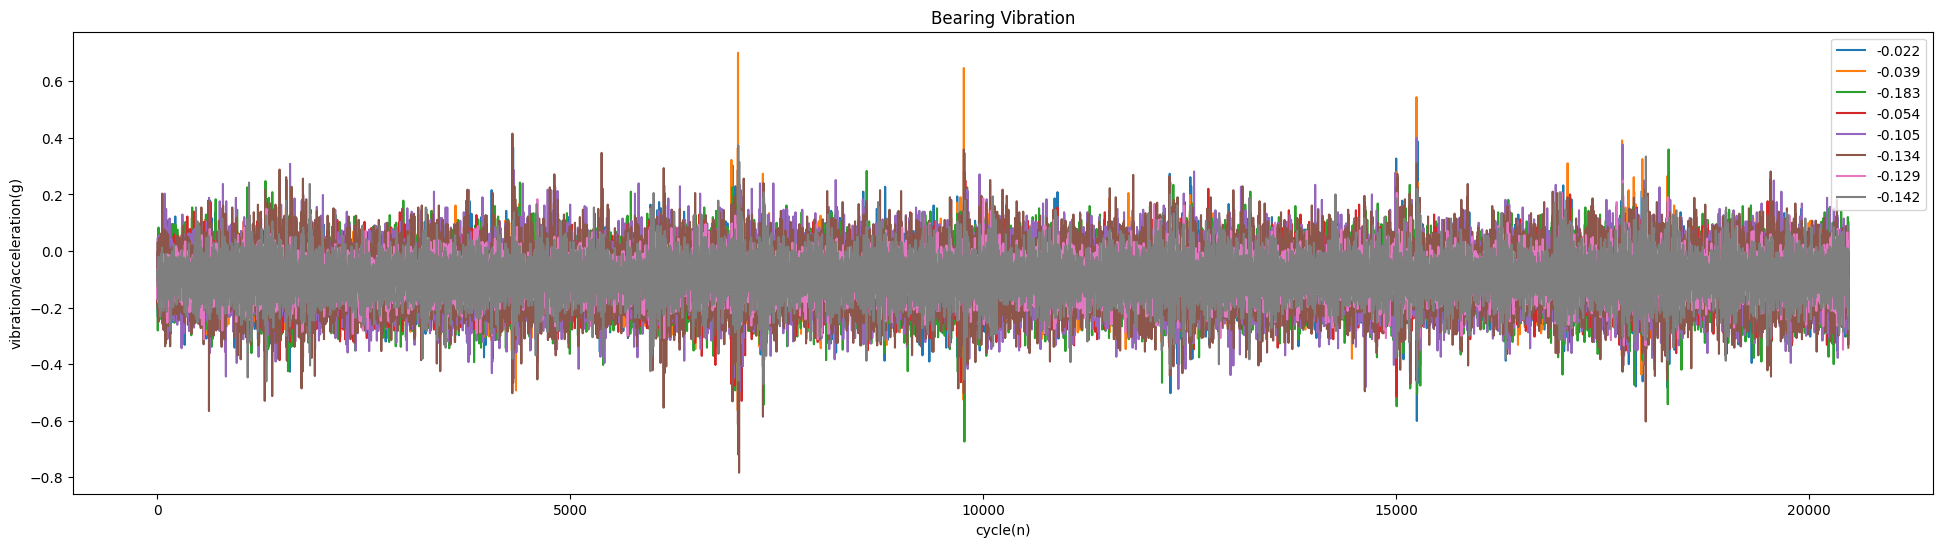

In [ ]:
# Test for the first file
dataset = pd.read_csv('/content/IMS/1st_test/2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

# Feature Extraction #

In this section several signal-based statistical features has been extracted from the data                                 
**Definition and formula of the features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:***
Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:***
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop.
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:***
Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults.
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:***
RMS divided by the mean of the absolute value. Shape factor is dependent on the signal shape while being independent of the signal dimensions.
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:***
Compare the height of a peak to the mean level of the signal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$


In [ ]:
# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']

    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)



    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')

        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs

        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])

        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])

        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename]

        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = pd.concat([data, merge]) # Use pd.concat instead of append

    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]

    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

# VQC

In [ ]:
set1 = time_features(dataset_path_1st, id_set=1)
set1.to_csv('set1_timefeatures.csv')

/tmp/ipython-input-2017997190.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, merge]) # Use pd.concat instead of append


In [ ]:
set1 = pd.read_csv("./set1_timefeatures.csv")
set1 = set1.rename(columns={'Unnamed: 0':'time'})
#set1 = set1.set_index('time')
last_cycle = int(len(set1))

In [ ]:
set2 = time_features(dataset_path_2nd, id_set=2)
set2.to_csv('set2_timefeatures.csv')

/tmp/ipython-input-2017997190.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, merge]) # Use pd.concat instead of append


In [ ]:
set2 = pd.read_csv("./set2_timefeatures.csv")
set2 = set2.rename(columns={'Unnamed: 0':'time'})
set2.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B1_crest,...,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearence,B4_shape,B4_impulse
0,2004-02-12 10:32:39,0.058333,0.073478,0.083929,0.629118,4.811406,0.074180,0.454,0.840,6.120246,...,-0.022081,0.066118,4.494251,0.054105,0.264,0.457,4.879424,0.036259,1.256305,6.130047
1,2004-02-12 10:42:39,0.058995,0.075339,0.052054,0.648930,4.835310,0.075382,0.388,0.757,5.147132,...,0.001645,0.107769,4.545837,0.056102,0.249,0.478,4.438343,0.037465,1.259558,5.590350
2,2004-02-12 10:52:39,0.060236,0.076189,0.032869,0.514258,4.848343,0.076228,0.503,0.903,6.598658,...,0.070516,0.257503,4.544783,0.056146,0.354,0.688,6.304948,0.037331,1.263332,7.965243
3,2004-02-12 11:02:39,0.061455,0.078694,0.041523,1.158352,4.761551,0.078726,0.608,1.184,7.723037,...,-0.036409,0.806635,4.553737,0.056808,0.525,1.038,9.241630,0.037989,1.260124,11.645601
4,2004-02-12 11:12:39,0.061361,0.078440,0.028134,0.603647,4.875062,0.078475,0.391,0.782,4.982488,...,0.019103,0.139316,4.560105,0.056841,0.244,0.456,4.292638,0.037949,1.259831,5.407997


In [ ]:
import pandas as pd, numpy as np, tensorflow as tf, pennylane as qml
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
DTYPE = "float64"

# 1. LOAD DATA
csv1 = Path("set1_timefeatures.csv")
csv2 = Path("set2_timefeatures.csv")
dfs  = []

def load_and_tag(csv_path: Path, tag: str):
    df = pd.read_csv(csv_path).rename(columns={'Unnamed: 0':'time'})
    df["file_id"] = tag
    df["cycle"]   = np.arange(len(df))
    df["RUL"]     = df["cycle"].max() - df["cycle"]
    return df

dfs.append(load_and_tag(csv1, "1st"))
dfs.append(load_and_tag(csv2, "2nd"))
features_df = pd.concat(dfs, ignore_index=True)

# Normalize RUL
rul_scaler = MinMaxScaler()
features_df["RUL_norm"] = rul_scaler.fit_transform(
    features_df["RUL"].values.reshape(-1,1)
).astype(DTYPE)

# ==== Feature selection and cleaning ====
EXCLUDE = {"time","file_id","cycle","RUL","RUL_norm"}
INPUT_COLS = [c for c in features_df.columns if c not in EXCLUDE]
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
INPUT_COLS = [c for c in INPUT_COLS if pd.api.types.is_numeric_dtype(features_df[c])]
all_nan_cols = [c for c in INPUT_COLS if features_df[c].isna().all()]
if all_nan_cols:
    features_df.drop(columns=all_nan_cols, inplace=True)
    INPUT_COLS = [c for c in INPUT_COLS if c not in all_nan_cols]
features_df[INPUT_COLS] = features_df[INPUT_COLS].apply(lambda col: col.fillna(col.median()))
scaler_X = MinMaxScaler()
features_df[INPUT_COLS] = scaler_X.fit_transform(features_df[INPUT_COLS])

# ==== PICK 8 BEST FEATURES ====
N_QUBITS = 8
all_X = features_df[INPUT_COLS].values
all_y = features_df["RUL_norm"].values

rf = RandomForestRegressor(random_state=SEED, n_estimators=100)
rf.fit(all_X, all_y)
importances = rf.feature_importances_
top_idx = np.argsort(importances)[::-1][:N_QUBITS]
SEL_COLS = [INPUT_COLS[i] for i in top_idx]
print("Top 8 features:", SEL_COLS)

Xq  = features_df[SEL_COLS].astype(DTYPE).to_numpy()
yq  = features_df["RUL_norm"].to_numpy()

# ==== Data checks ====
print("NaNs in Xq:", np.isnan(Xq).sum(), "NaNs in yq:", np.isnan(yq).sum())
print("Infs in Xq:", np.isinf(Xq).sum(), "Infs in yq:", np.isinf(yq).sum())
print("Min, max Xq:", np.min(Xq), np.max(Xq))
assert np.all(np.isfinite(Xq)) and np.all(np.isfinite(yq)), "Check data!"

Xq_tr, Xq_te, yq_tr, yq_te = train_test_split(Xq, yq, test_size=0.3, random_state=SEED)

# ==== PENNYLANE DEVICE ====
dev = qml.device("default.qubit", wires=N_QUBITS)

# ==== CIRCUIT DEFINITION ====
N_LAYERS = 5

def angle_encode(x):
    # Rescale [0,1] -> [-π/2, π/2] for better QML stability
    for i in range(N_QUBITS):
        qml.RY((x[i] - 0.5) * np.pi, wires=i)

def ansatz(params):
    params = tf.reshape(params, (N_LAYERS, N_QUBITS, 3))
    for layer in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RX(params[layer, i, 0], wires=i)
            qml.RY(params[layer, i, 1], wires=i)
            qml.RZ(params[layer, i, 2], wires=i)
        for i in range(N_QUBITS):
            qml.CNOT(wires=[i, (i+1)%N_QUBITS])

@qml.qnode(dev, interface="tf", diff_method="backprop")
def circuit(inputs, weights):
    angle_encode(inputs)
    ansatz(weights)
    return qml.expval(qml.PauliZ(0))

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.w = self.add_weight(
            name="weights",
            shape=(N_LAYERS * N_QUBITS * 3,),
            initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05),
            trainable=True,
            dtype=DTYPE)
    def call(self, inputs):
        inputs = tf.cast(inputs, DTYPE)
        w = tf.cast(self.w, DTYPE)
        vals = tf.map_fn(
            lambda x: circuit(x, w),
            inputs,
            fn_output_signature=tf.float64
        )
        return tf.expand_dims(vals, 1)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)

# ==== BUILD MODEL ====
qin   = tf.keras.Input(shape=(N_QUBITS,), dtype=DTYPE)
qval  = QuantumLayer()(qin)
dense1 = tf.keras.layers.Dense(32, activation="relu", dtype=DTYPE)(qval)
# bn1    = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(16, activation="relu", dtype=DTYPE)(dense1)
# bn2    = tf.keras.layers.BatchNormalization()(dense2)
qout   = tf.keras.layers.Dense(1, activation="linear", dtype=DTYPE)(dense2)
qmodel = tf.keras.Model(qin, qout)

qmodel.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
qmodel.summary()

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

history = qmodel.fit(
    Xq_tr, yq_tr,
    validation_data=(Xq_te, yq_te),
    epochs=100,
    batch_size=8,  # Use 8 for quantum layers (big batch may crash)
    callbacks=callbacks,
    verbose=2
)


Top 8 features: ['B4_x_std', 'B1_y_std', 'B2_y_shape', 'B4_y_std', 'B1_x_rms', 'B4_x_rms', 'B3_x_rms', 'B1_rms']
NaNs in Xq: 0 NaNs in yq: 0
Infs in Xq: 0 Infs in yq: 0
Min, max Xq: 0.0 1.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_layer (QuantumLayer)    │ (None, 1)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729 (5.70 KB)

 Trainable params: 729 (5.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/tmp/ipython-input-3726036656.py:111: PennyLaneDeprecationWarning: Support for the TensorFlow interface is deprecated and will be removed in v0.44. Future versions of PennyLane are not guaranteed to work with TensorFlow. Please migrate your workflows to JAX or Pytorch to benefit from enhanced support and features.
  lambda x: circuit(x, w),


275/275 - 109s - 395ms/step - loss: 0.1513 - mae: 0.3004 - val_loss: 0.1080 - val_mae: 0.2582 - learning_rate: 1.0000e-04
Epoch 2/100
275/275 - 81s - 296ms/step - loss: 0.0905 - mae: 0.2441 - val_loss: 0.0873 - val_mae: 0.2419 - learning_rate: 1.0000e-04
Epoch 3/100
275/275 - 78s - 284ms/step - loss: 0.0796 - mae: 0.2342 - val_loss: 0.0799 - val_mae: 0.2332 - learning_rate: 1.0000e-04
Epoch 4/100
275/275 - 84s - 305ms/step - loss: 0.0715 - mae: 0.2233 - val_loss: 0.0707 - val_mae: 0.2192 - learning_rate: 1.0000e-04
Epoch 5/100
275/275 - 62s - 225ms/step - loss: 0.0594 - mae: 0.2034 - val_loss: 0.0569 - val_mae: 0.1947 - learning_rate: 1.0000e-04
Epoch 6/100
275/275 - 79s - 287ms/step - loss: 0.0448 - mae: 0.1749 - val_loss: 0.0427 - val_mae: 0.1646 - learning_rate: 1.0000e-04
Epoch 7/100
275/275 - 56s - 203ms/step - loss: 0.0332 - mae: 0.1464 - val_loss: 0.0333 - val_mae: 0.1422 - learning_rate: 1.0000e-04
Epoch 8/100
275/275 - 82s - 297ms/step - loss: 0.0269 - mae: 0.1298 - val_loss: 

/tmp/ipython-input-3726036656.py:111: PennyLaneDeprecationWarning: Support for the TensorFlow interface is deprecated and will be removed in v0.44. Future versions of PennyLane are not guaranteed to work with TensorFlow. Please migrate your workflows to JAX or Pytorch to benefit from enhanced support and features.
  lambda x: circuit(x, w),


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 423ms/step


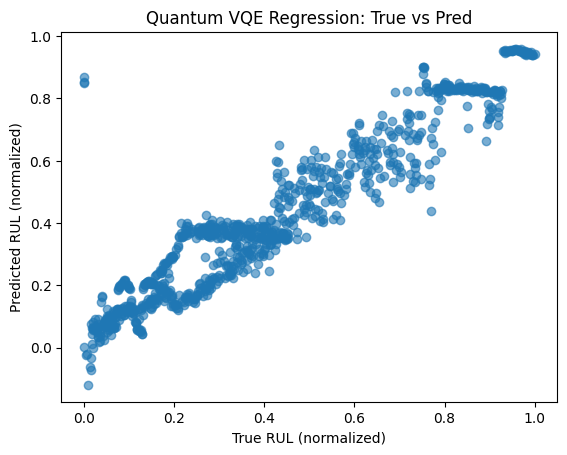

In [ ]:
import matplotlib.pyplot as plt
y_pred = qmodel.predict(Xq_te)
plt.scatter(yq_te, y_pred, alpha=0.6)
plt.xlabel("True RUL (normalized)")
plt.ylabel("Predicted RUL (normalized)")
plt.title("Quantum VQE Regression: True vs Pred")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

start_time = time.time()

# --- Predict ---
y_pred = qmodel.predict(Xq_te).flatten()
y_true = yq_te

# --- Undo normalization if you want "real" RUL values ---
y_pred_rescaled = rul_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_rescaled = rul_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# --- Metrics ---
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

mse_real = mean_squared_error(y_true_rescaled, y_pred_rescaled)
mae_real = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
r2_real = r2_score(y_true_rescaled, y_pred_rescaled)

end_time = time.time()
elapsed_time = end_time - start_time

# --- Print All Results ---
print("🧑‍💻 **VQE Quantum Regression Model Evaluation:**")
print("  Normalized RUL:")
print(f"    - MSE: {mse:.6f}")
print(f"    - MAE: {mae:.6f}")
print(f"    - R2 Score: {r2:.6f}")
print("  Rescaled RUL:")
print(f"    - MSE: {mse_real:.2f}")
print(f"    - MAE: {mae_real:.2f}")
print(f"    - R2 Score: {r2_real:.4f}")
print(f"🕒 Inference time: {elapsed_time:.2f} seconds\n")

qmodel.summary()


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step
🧑‍💻 **VQE Quantum Regression Model Evaluation:**
  Normalized RUL:
    - MSE: 0.007902
    - MAE: 0.062233
    - R2 Score: 0.901641
  Rescaled RUL:
    - MSE: 36696.11
    - MAE: 134.11
    - R2 Score: 0.9016
🕒 Inference time: 10.31 seconds



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_layer (QuantumLayer)    │ (None, 1)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189 (17.10 KB)

 Trainable params: 729 (5.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,460 (11.40 KB)

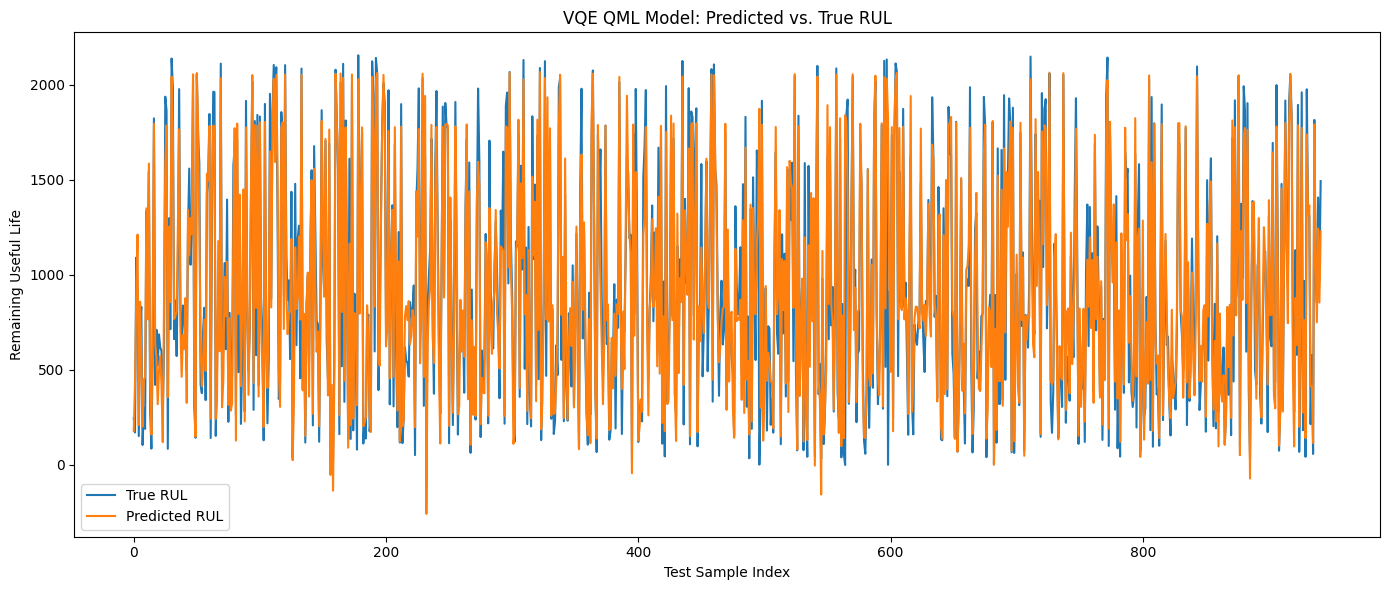

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_true_rescaled, label="True RUL")
plt.plot(y_pred_rescaled, label="Predicted RUL")
plt.xlabel("Test Sample Index")
plt.ylabel("Remaining Useful Life")
plt.title("VQE QML Model: Predicted vs. True RUL")
plt.legend()
plt.tight_layout()
plt.show()


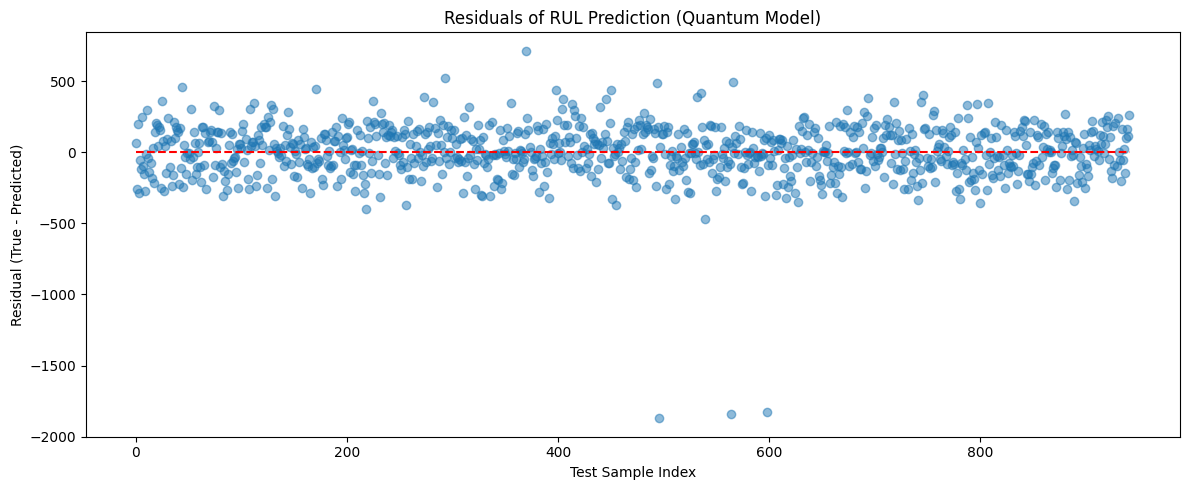

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(range(len(y_true_rescaled)), y_true_rescaled - y_pred_rescaled, alpha=0.5)
plt.hlines(0, 0, len(y_true_rescaled), colors="r", linestyles="dashed")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals of RUL Prediction (Quantum Model)")
plt.tight_layout()
plt.show()


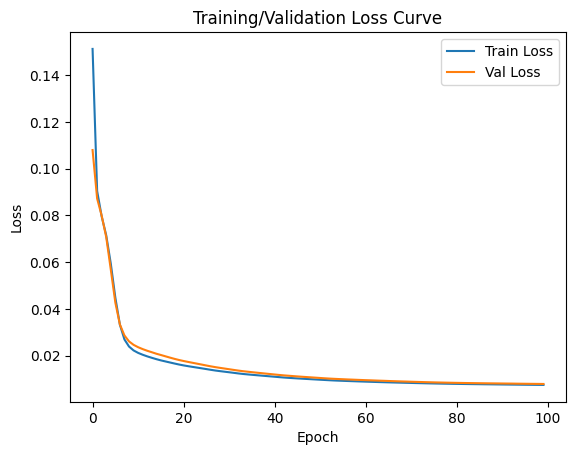

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss Curve')
plt.show()


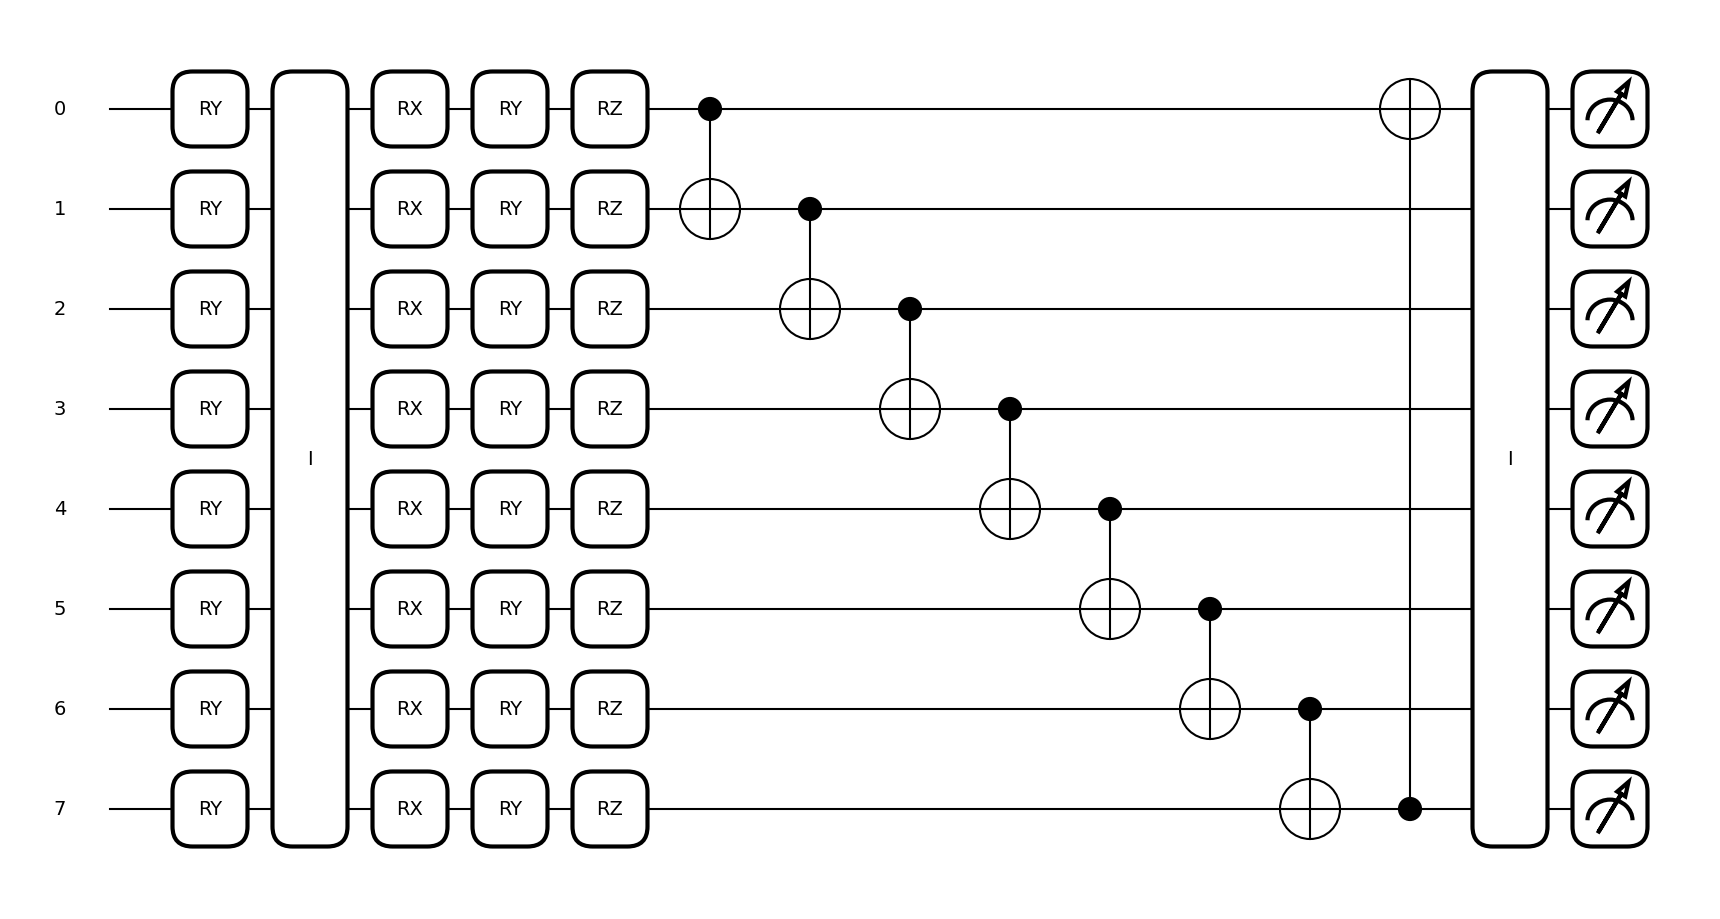

In [ ]:
import pennylane as qml
from pennylane import numpy as np

N_QUBITS = 8
N_LAYERS = 1
dev = qml.device("default.qubit", wires=N_QUBITS)

def angle_encode(x):
    # Feature Encoding Block (RY rotations)
    for i in range(N_QUBITS):
        qml.RY((x[i] - 0.5) * np.pi, wires=i)

def add_separator(label=" "):
    # Adds a barrier-like visual break (for presentation only)

    qml.Identity(wires=7)
    # Add a label in your slide or using matplotlib text

def ansatz(params):
    # Variational Quantum Circuit (VQC) block
    params = np.reshape(params, (N_LAYERS, N_QUBITS, 3))
    for layer in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RX(params[layer, i, 0], wires=i)
            qml.RY(params[layer, i, 1], wires=i)
            qml.RZ(params[layer, i, 2], wires=i)
        for i in range(N_QUBITS):
            qml.CNOT(wires=[i, (i+1)%N_QUBITS])

@qml.qnode(dev)
def circuit(x, weights):
    angle_encode(x)
    add_separator("Feature Encoding done")
    ansatz(weights)
    # Measurement step is implicit in expval, but add another separator
    add_separator("Measurement")
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# Dummy input for visualization
x_dummy = np.zeros(N_QUBITS)
w_dummy = np.zeros((N_LAYERS, N_QUBITS, 3))

# Visualize (matplotlib)
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(x_dummy, w_dummy)
